# 0. 모듈 임포트 하고 데이터 파일 불러오기

In [1]:
# 모듈 임포트

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
# 파일 불러오기

air_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_reserve.csv')
air_store_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv')
air_visit_data = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv')
hpg_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv')
store_id_relation = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv')
date_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/date_info.csv')
weather_data = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv')
area_name_mapping = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/area_name_mapping.csv')
sample_submission = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv')

# 1. 데이터 전처리.  Data Preprocessing
## 1-1. 날짜, 날씨 데이터 전처리
test set에 가까운 최근 날짜일 수록 높은 가중치 부여

In [3]:
# preprocessing Date Info.

date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)
# 컬럼명 일치시키기
date_info['weight'] = ((date_info.index + 1.0) / len(date_info)) ** 5.0
# 날짜 가중치 부여

In [4]:
# preprocessing Weather data

weather_data.rename(columns={'area_name': 'weather_area', 'calendar_date':'visit_date'},inplace=True)
# 컬럼명 일치시키기

weather_data['visit_date'] = pd.to_datetime(weather_data['visit_date']).astype(str)
# 날짜를 데이터타임 형식으로 변환

area_name_mapping.rename(columns={'station_id':'weather_area'},inplace=True)
# 컬럼명 일치시키기

weather_data.isnull().sum()
# 결측치 확인

weather_area              0
visit_date                0
precipitation          3623
avg_temperature        4152
total_snowfall        28911
deepest_snowfall      28404
hours_sunlight         7265
avg_wind_speed         4245
avg_vapor_pressure    23282
avg_humidity          23282
avg_sea_pressure      23265
avg_local_pressure    23265
solar_radiation       26884
cloud_cover           25850
high_temperature       4152
low_temperature        4152
dtype: int64

In [5]:
weather_data = weather_data.drop(['total_snowfall', 'deepest_snowfall', 'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure','avg_humidity', 'avg_sea_pressure', 'avg_local_pressure', 'solar_radiation', 'cloud_cover'], axis=1)
# 결측치 너무 많은 컬럼 삭제 (전체 값 중에 약 75% 이상이 결측치일 경우)

weather_data['precipitation'].fillna(0)
# 강수량 결측치는 0으로 채우기

weather_data = weather_data.interpolate(method='values')
# 중간중간 빈칸은 주위 값으로 채우기

weather_data

,weather_area,visit_date,precipitation,avg_temperature,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,12.3,7.1
...,...,...,...,...,...,...
33083,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-27,0.0,19.2,23.6,14.3
33084,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-28,0.0,21.3,28.0,15.7
33085,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-29,0.0,23.2,27.7,19.2
33086,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-30,0.0,23.6,28.8,19.4


## 1-2. air 방문자 데이터 전처리

In [6]:
# air 방문자 데이터 전처리

air_data = pd.merge(air_visit_data,air_store_info,how='left', on=['air_store_id'])
# air_store_id 기준으로 방문자 데이터와 매장 데이터 병합

air_data = pd.merge(air_data,date_info,how='left', on=['visit_date'])
# visit_date 기준으로 방문자 데이터와 날짜 데이터 병합

air_data = pd.merge(air_data,area_name_mapping,how='left', on=['air_area_name'])
# 기상 관측소 위치 병합

air_data = pd.merge(air_data,weather_data,how='left', on=['weather_area', 'visit_date'])
# 날씨 데이터 병합

air_data.sort_values(by='visit_date',ignore_index=True,inplace=True)
# 날짜 순으로 정렬

air_data['visit_date'] = pd.to_datetime(air_data['visit_date'])
# 날짜를 데이터타임 형식으로 변환

air_data['day'] = air_data['visit_date'].dt.day
air_data['dow'] = air_data['visit_date'].dt.weekday
air_data['year'] = air_data['visit_date'].dt.year
air_data['month'] = air_data['visit_date'].dt.month
air_data['week'] = air_data['visit_date'].dt.week
air_data['quarter'] = air_data['visit_date'].dt.quarter
air_data['visit_date'] = air_data['visit_date'].dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## 1-3. air 예약자 데이터 전처리

In [7]:
# air 예약자 데이터 전처리

air_reserve_data = pd.merge(air_reserve,air_store_info,how='left', on=['air_store_id'])
# air_store_id 기준으로 예약자 데이터와 매장 데이터 병합

air_reserve_data['visit_datetime'] = pd.to_datetime(air_reserve_data['visit_datetime'])
# 날짜를 데이터타임 형식으로 변환

air_reserve_data['visit_hour'] = air_reserve_data['visit_datetime'].dt.hour
air_reserve_data['visit_date'] = air_reserve_data['visit_datetime'].dt.date
air_reserve_data['reserve_datetime'] = pd.to_datetime(air_reserve_data['reserve_datetime'])
air_reserve_data['reserve_hour'] = air_reserve_data['reserve_datetime'].dt.hour
air_reserve_data['reserve_date'] = air_reserve_data['reserve_datetime'].dt.date
air_reserve_data.rename(columns={'reserve_visitors':'air_reserve_visitors'},inplace=True)

## 1-4. hpg 예약자 데이터 전처리

In [8]:
# hpg 예약자 데이터 전처리

hpg_reserve_data = pd.merge(hpg_reserve,store_id_relation,on=['hpg_store_id'],how='inner')
# hpg_store_id 기준으로 air id 병합

hpg_reserve_data = pd.merge(hpg_reserve_data,hpg_store_info,on=['hpg_store_id'],how='left')
# hpg_store_id 기준으로 방문자 데이터와 매장 데이터 병합

hpg_reserve_data['visit_datetime'] = pd.to_datetime(hpg_reserve_data['visit_datetime'])
# 날짜를 데이터타임 형식으로 변환

hpg_reserve_data['visit_hour'] = hpg_reserve_data['visit_datetime'].dt.hour
hpg_reserve_data['visit_date'] = hpg_reserve_data['visit_datetime'].dt.date
hpg_reserve_data['reserve_datetime'] = pd.to_datetime(hpg_reserve_data['reserve_datetime'])
hpg_reserve_data['reserve_hour'] = hpg_reserve_data['reserve_datetime'].dt.hour
hpg_reserve_data['reserve_date'] = hpg_reserve_data['reserve_datetime'].dt.date
hpg_reserve_data.rename(columns={'reserve_visitors':'hpg_reserve_visitors'},inplace=True)

In [9]:
air_data

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,weight,...,precipitation,avg_temperature,high_temperature,low_temperature,day,dow,year,month,week,quarter
0,air_fab092c35776a9b1,2016-01-01,19,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,Friday,1,2.707368e-14,...,0.0,7.300000,12.600000,3.100000,1,4,2016,1,53,1
1,air_f26f36ec4dc5adb0,2016-01-01,64,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,Friday,1,2.707368e-14,...,0.0,7.500000,12.100000,3.600000,1,4,2016,1,53,1
2,air_d97dabf7aae60da5,2016-01-01,102,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,Friday,1,2.707368e-14,...,0.0,7.500000,12.100000,3.600000,1,4,2016,1,53,1
3,air_39dccf7df20b1c6a,2016-01-01,55,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,Friday,1,2.707368e-14,...,0.0,22.690722,29.189562,17.592010,1,4,2016,1,53,1
4,air_79f528087f49df06,2016-01-01,42,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,Friday,1,2.707368e-14,...,0.0,6.900000,11.800000,2.100000,1,4,2016,1,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_6a15e4eae523189d,2017-04-22,12,Bar/Cocktail,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Saturday,0,6.755955e-01,...,15.0,14.300000,18.400000,9.700000,22,5,2017,4,16,2
252104,air_bf13014b6e3e60ca,2017-04-22,49,Cafe/Sweets,Tōkyō-to Setagaya-ku Setagaya,35.646572,139.653247,Saturday,0,6.755955e-01,...,15.5,8.735521,13.451351,4.773745,22,5,2017,4,16,2
252105,air_c52c63c781fe48f6,2017-04-22,41,Cafe/Sweets,Fukuoka-ken Itoshima-shi Maebarunishi,33.557320,130.195555,Saturday,0,6.755955e-01,...,0.0,15.300000,19.900000,10.300000,22,5,2017,4,16,2
252106,air_59cc9b2b209c6331,2017-04-22,12,Cafe/Sweets,Tōkyō-to Setagaya-ku Setagaya,35.646572,139.653247,Saturday,0,6.755955e-01,...,15.5,8.735521,13.451351,4.773745,22,5,2017,4,16,2


----

# 2. 데이터 시각화 및 분석.  Data Visualization, EDA

## 2-1. 고유 상점 수

Text(0.5, 1.0, 'Number Unique Store ID')

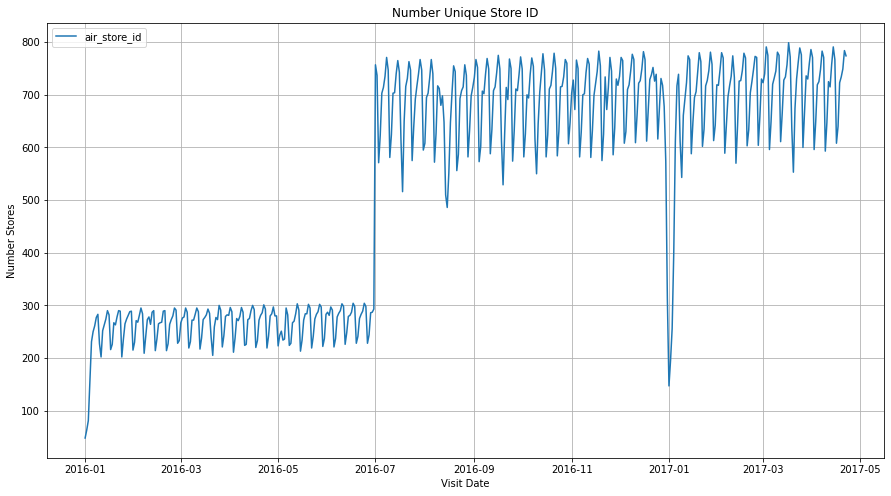

In [10]:
f,ax = plt.subplots(1,1, figsize=(15,8))
stores= air_data.groupby(['visit_date'])['air_store_id'].size()
stores.plot(kind='line', grid=True, ax=ax, legend=True)
plt.ylabel("Number Stores")
plt.xlabel("Visit Date")
plt.title("Number Unique Store ID")

>분석  
>-  해당 날짜에 문을 연 식당 수 그래프  
>- 1달에 4번 정도의 주기로 규칙적인 패턴이 보인다.  
>- 1달에 4번 정도의 주기로 규칙적인 패턴이 보인다.  
>- 1월 1일에는 외식을 하는 사람이 적다(연초를 가족과 함께 보내는 문화인 것 같다).  
>- 중간에 방문자 수가 급격히 늘어난 것은 시스템 상에 매장이 추가 된 영행으로 보인다.  

## 2-2. 총 방문자 및 예약 수

Text(0.5, 1.0, 'Visitor and Reservations')

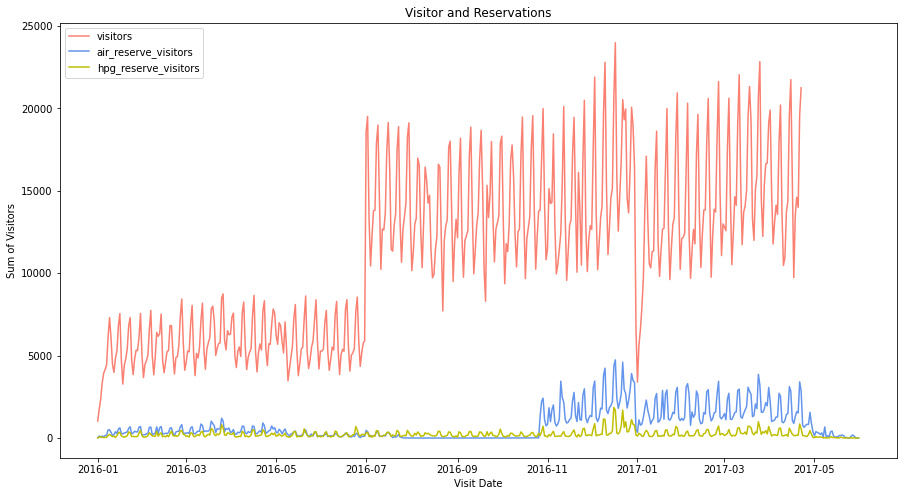

In [11]:
f,ax = plt.subplots(1,1,figsize=(15,8))
plt1 = air_data.groupby(['visit_date'])['visitors'].sum().to_frame()
plt2 = air_reserve_data.groupby(['visit_date'])['air_reserve_visitors'].sum().to_frame()
plt3 = hpg_reserve_data.groupby(['visit_date'])['hpg_reserve_visitors'].sum().to_frame()
plt1.plot(color='salmon', kind='line', ax=ax)
plt2.plot(color='cornflowerblue', kind='line', ax=ax)
plt3.plot(color='y', kind='line', ax=ax)
plt.legend()
plt.ylabel("Sum of Visitors")
plt.xlabel("Visit Date")
plt.title("Visitor and Reservations")

>분석  
>- 16년 5월즈음부터 air 예약이 거의 0 이 된 것이 이상해서 따로 찾아보았더니, 그 즈음에 AirREGI 에서 음식점이 예약을 관리할 수 있는 어플리케이션을 새로 출시했다고 한다.
새로 시작한 사업에 힘을 쏟느라 그나마 있던 예약 건수가 줄어들었다가 뒤늦게 홍보나 마케팅 사업을 해서 갑자기 늘었을 수도 있고,
아니면 예약 데이터를 새 어플쪽에서 관리하다가 10월 정도에 다시 이 데이터에 반영됐을 수도 있을 것 같다.
>- 예약 데이터의 그래프 형태는 방문자의 그래프 형태와 비슷하다.
>- air의 예약 데이터가 안 잡히는 구간을 제외하면 전체적으로 air를 통한 예약이 hpg를 통한 예약보다 많다.
>- 연말에 예약자 수가 증가하는데 연말의 송년회 분위기는 일본도 마찬가지인가보다.

## 2-3. 레스토랑 당 평균 방문자 수

__레스토랑 당 평균 방문자 수 확률 밀도 함수(PDF)__

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


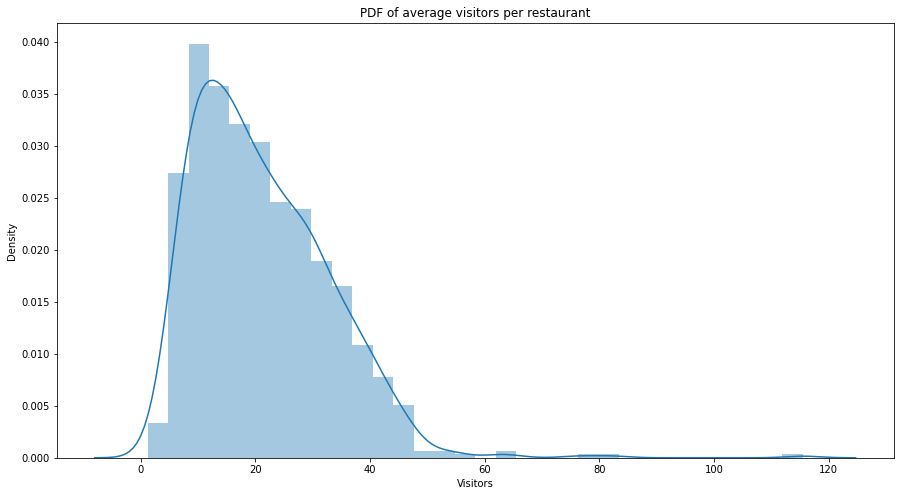

In [12]:
temp = air_data.groupby(['air_store_id'])['visitors'].mean().to_frame()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=temp.visitors.values, ax=ax)
plt.xlabel('Visitors')
plt.ylabel('Density')
plt.title('PDF of average visitors per restaurant')
plt.show()

__레스토랑 당 평균 방문자 수 Box Plot__

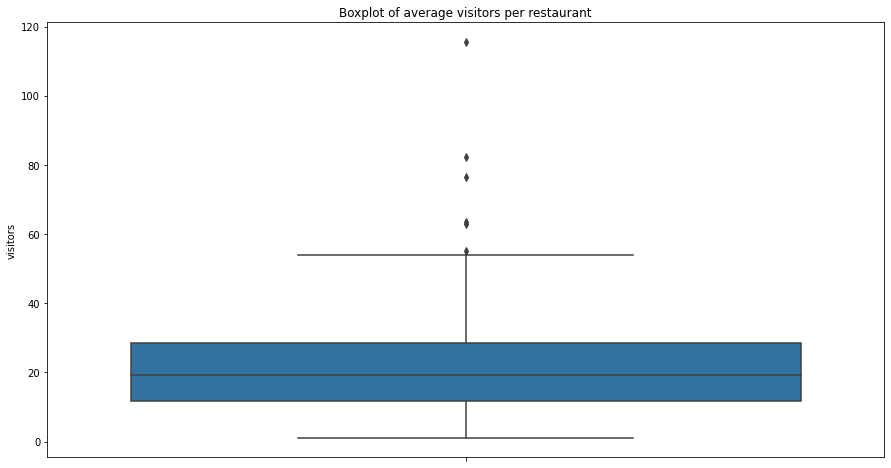

In [13]:
f,ax = plt.subplots(1,1, figsize=(15,8))
sns.boxplot(y='visitors', data=temp,ax=ax)
plt.title('Boxplot of average visitors per restaurant')
plt.show()

>분석  
>- 해당 기간동안 매장별로 일 평균 방문자 그래프.
>- 하루 평균 방문자 수 평균은 21명이고, 대부분이 20명대에 몰려있다.
>- 가장 방문자수가 적은 경우는 약 1명이고, 많게는 115명까지 있는데 이상치 확인이 필요해 보인다.
>- 크지는 않지만 약간 왼쪽으로 치우친 형태여서 로그변환을 했을 경우 성능이 증가 할까?
>- boxplot에서 이상치인 점이 5개정도 발견되는데 하나만 너무 떨어져있어서 확인이 필요하다.

## 2-4. 레스토랑 장르별 시장 점유율

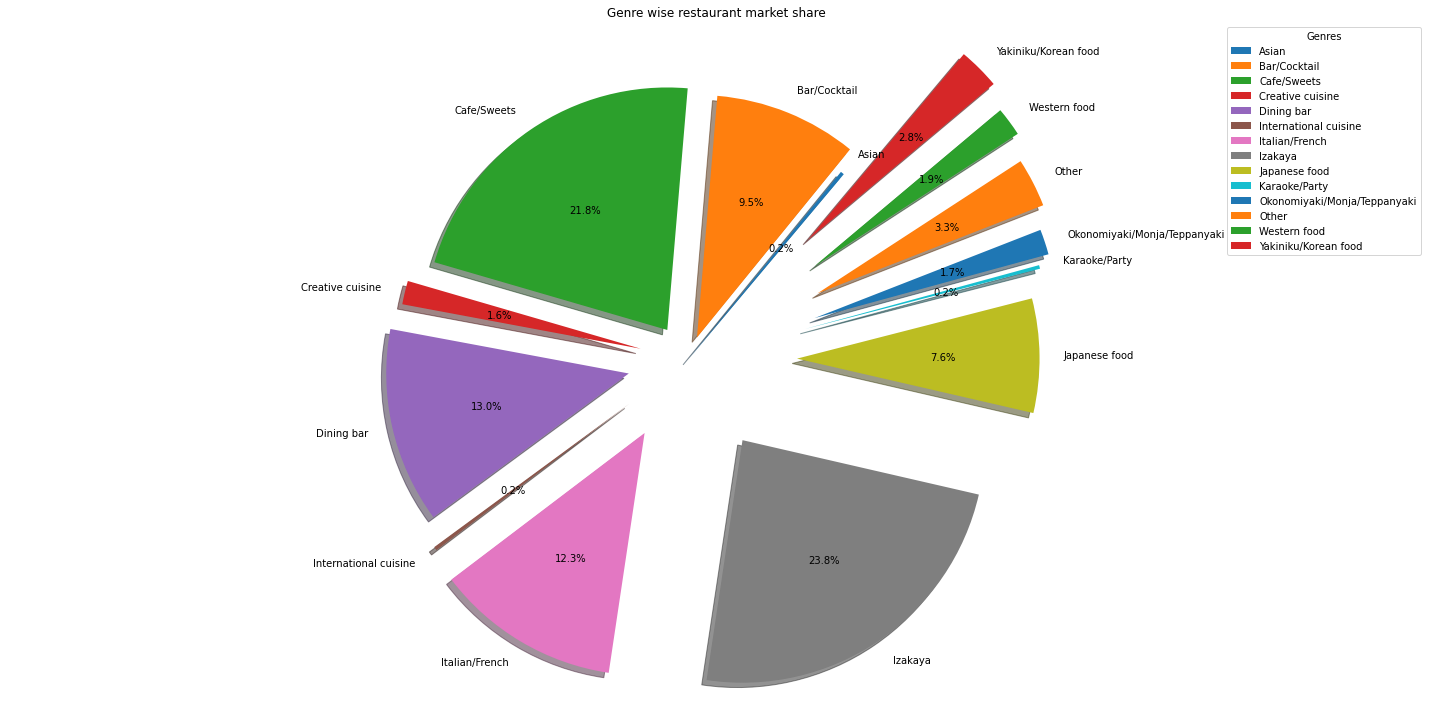

In [14]:
temp = air_store_info.groupby(['air_genre_name'],as_index=False)['air_store_id'].count()
# Pie chart
labels = temp.air_genre_name.values
sizes = temp.air_store_id.values
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7)  
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Genres')
plt.title('Genre wise restaurant market share')
plt.show()

>분석  
>- 가장 인기있는 유형의 식당은 주로 이자카야, 카페, 다이닝바가 있다.
>- 전체적인 유형은 일반식당 40%, 술집 40%, 카페 20% 정도임을 확인할 수 있었다.
>- 비인기 유형은 주로 이탈리아/프랑스 음식을 제외한 기타 해외 음식류이다.

## 2-5. 레스토랑 장르별 총 방문자 수

Text(0.5, 1.0, 'Total visitors by air_genre_name')

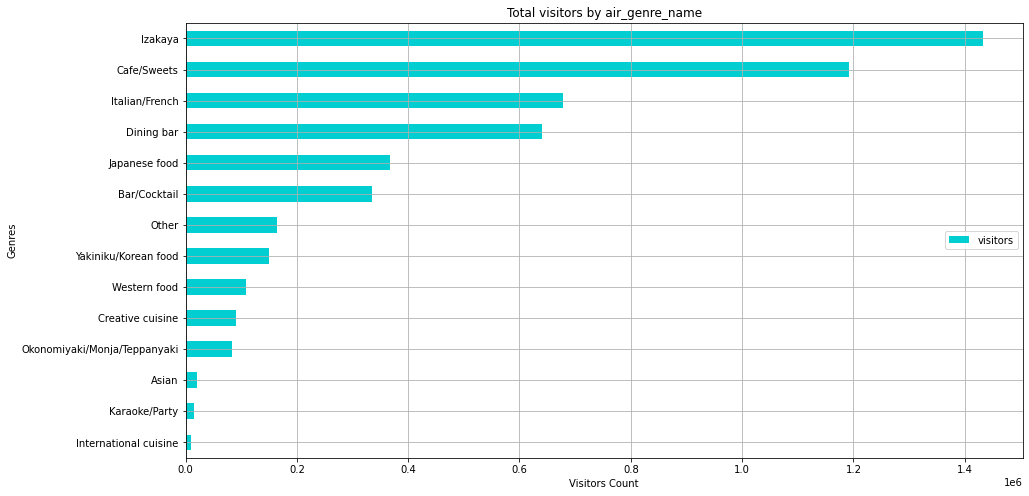

In [15]:
f,ax = plt.subplots(1,1, figsize=(15,8))
genre = air_data.groupby(['air_genre_name'])['visitors'].sum().to_frame()
genre.sort_values(by='visitors',inplace=True)
genre.plot(kind='barh',color= 'darkturquoise', grid=True, ax=ax, legend=True)
plt.ylabel('Genres')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Total visitors by air_genre_name", loc='center')

>분석  
>- 앞서 나타낸 원형 그래프와 약간의 차이가 존재한다.
>- 시장 점유율을  한가지 예를 고려해 다시 살펴보고자 한다.
>   - 시장 점유율
>    - 다이닝바 : 3위,  프랑스음식점 : 4위
>  - 총 방문자 수
>    - 프랑스음식점 : 3위, 다이닝바 : 4위

>    - 두가지의 순위가 상반된다.  해당 이유는 2가지 정도 생각할 수 있다. 첫째, 식당에서 다같이 밥을 먹고 비교적 2차는 음주를 선호하는 사람들과 추가적으로 가기 때문일 것이다. 두번째 이유로는 프랑스음식점은 레스토랑으로 비교적 가족단위도 많이 즐길 수 있다. 반면 다이닝 바는 평소에도, 1인 혹은 2인 단위의 커플이나 친구들과 방문하는 경향이 있어 방문자 수에 차이를 보이는 것이라 생각하였다.
>-  만일 방문자 수 예측 시, 식당 장르를 feature로 사용하고자 한다면 총 방문자수 또한 고려해 보아야 한다.
>    - ex) 비슷한 장르를 묶은 총 4~5개의 카테고리로 나눈 데이터를 통한 모델학습

## 2-6 . 레스토랑 장르별 평균 방문자 수

Text(0.5, 1.0, 'Average visitors by air_genre_name')

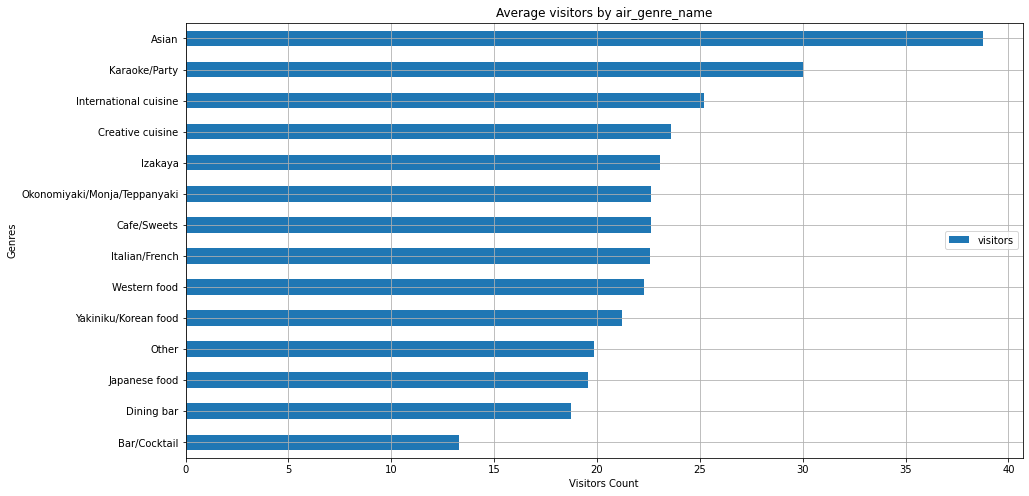

In [16]:
f,ax = plt.subplots(1,1, figsize=(15,8))
genre = air_data.groupby(['air_genre_name'])['visitors'].mean().to_frame()
genre.sort_values(by='visitors',inplace=True)
genre.plot(kind='barh', grid=True, ax=ax, legend=True)
plt.ylabel('Genres')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Average visitors by air_genre_name", loc='center')

## 2-7. 요일별 연간 방문자 동향

Text(0.5, 1.0, 'Visitors by Day of the Week ')

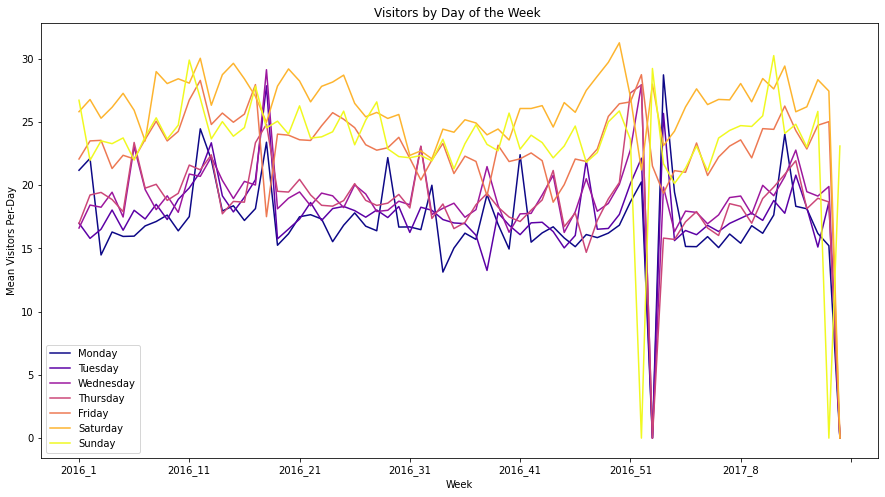

In [17]:
dow=pd.pivot_table(air_data, index=['year','week'], columns='dow',values='visitors',aggfunc=[np.mean],fill_value=0)
dow=pd.DataFrame(dow.to_records())
dow['year_week']=dow['year'].astype(str) +'_'+ dow['week'].astype(str)
dow.index = dow['year_week']
dow.drop(['year','week','year_week'],axis=1,inplace=True)
dow.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

f, ax=plt.subplots(1,1, figsize=(15,8))
dow.plot(kind='line', ax=ax, cmap='plasma')
plt.ylabel("Mean Visitors Per-Day")
plt.xlabel("Week")
plt.title("Visitors by Day of the Week ")

>분석  
>- 금, 토,일 (갈색, 주황색, 노란색) 방문자수 와 월화수목 방문자수 간의 차이가 확연히 보인다.
>- 1월 1일에 식당 방문자가 거의 없다. 그 이유는 1월1일에 문을 닫는 식당이 많기 때문인 것을 예상된다.
>- 월화수목 방문자 수가 금토일 방문자수를 뛰어넘는 구간(2016_20, 2016_51부분)이 존재한다. 이것은 골든 위크 효과와 연말 효과일 가능성이 크다.

## 2-8. 요일별 평균 방문자 수

Text(0.5, 1.0, 'Average Visitors Each Day Of Week')

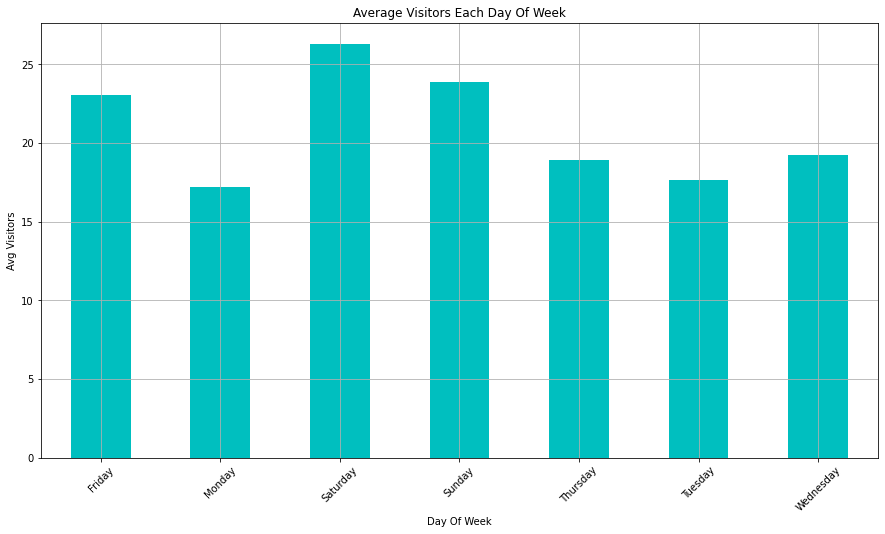

In [18]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['day_of_week'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'c', grid=True, ax=ax, legend=False)
plt.xticks(rotation=45)
plt.xlabel('Day Of Week')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Week')

>분석  
>- <요일별 연간 방문자 동향> 그래프보다 요일별 평균 방문객 수를 직관적으로 보여주는 그래프이다.
>- 금, 토,일이 방문자 수가 많고 월,화가 방문자 수가 적다.
>- 평균 방문자수가 최대인 요일은 토요일이고, 최소인 요일은 월요일이다. 그 차이는 약 1.5배 정도 이다.
>- 금요일은 평일이지만 다음 날이 쉬는 날이라 외식이 증가한 것 같다.

## 2-9. 일 별 평균 방문자 수

Text(0.5, 1.0, 'Average Visitors Each Day Of Month')

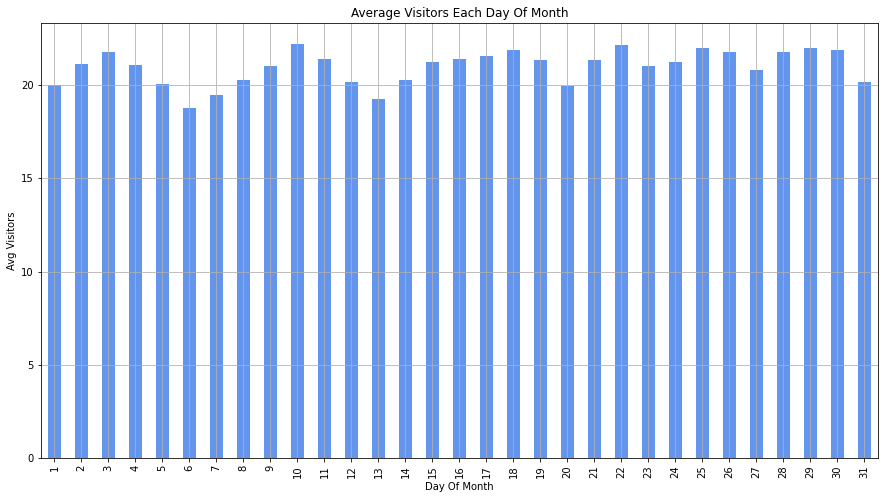

In [19]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['day'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'cornflowerblue', grid=True, ax=ax,legend=False)
plt.xlabel('Day Of Month')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Month')

>분석  
>- 일본의 월급날과 보릿고개를 알 수 있다. 방문자 수의 굴곡의 극값을 보며 예측 가능하다.
    - 월급일 : 3일, 10일, 22일이 비교적 상위에 있는 것으로 보아 월급일로 추정한다.
    - 보릿고개 : 31일, 6일, 20일 (월급일 직전)
>- 13일은 명확하지 않다. 13일의 금요일?
>- 일별 방문자수가 증가했다가 감소하는 일정한 주기가 존재한다.
>- 월 말에는 방문자수 증감이 평이하며 비교적 높은값에서 일정하게 유지된다. 

## 2-10. 월 평균 방문자 수

Text(0.5, 1.0, 'Monthly Average Visitors')

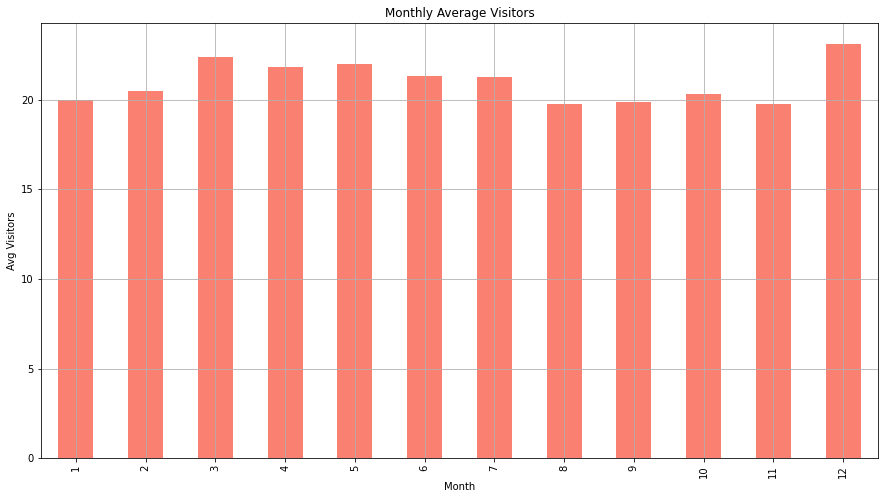

In [20]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['month'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'salmon', grid=True, ax=ax,legend=False)
plt.xlabel('Month')
plt.ylabel('Avg Visitors')
plt.title('Monthly Average Visitors')

>분석  
>- 월별 방문자 수 원인을 추측해 보았다.
>    - 3월 :  신학기, 벚꽃축제
>    - 12월 : 송년회 효과
>    - 8월 : 더운 날씨, 장마 혹은 방학주간
>    - 11월 : 공휴일이 없는 달, 겨울에 접어드는 기온 변화
>    - 1월 : 1월1일 효과

>- 만일 코로나 같은 특수한 상황을 제외하고, 단 한가지 지표만으로 식당 방문자수를 예측해야한다면 바로 이것을 통해 가능할 것이 아닐까 싶다.

## 2-11. 공휴일 및 비공휴일 평균 방문자 수

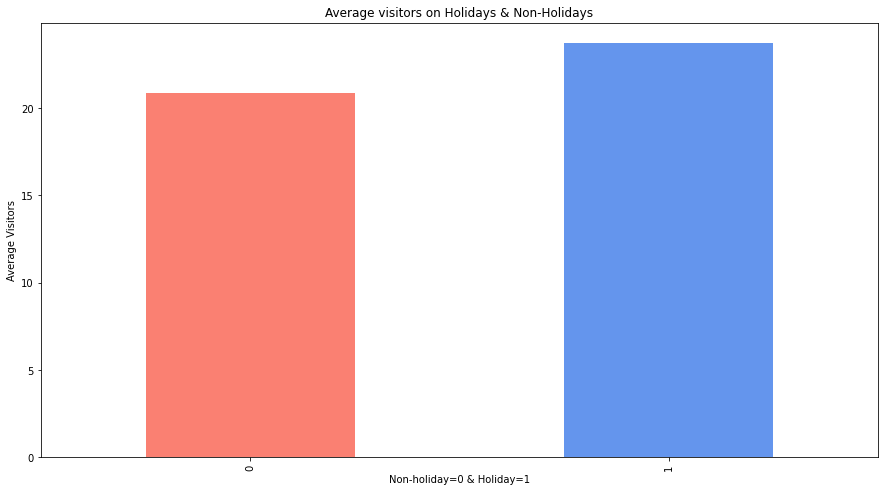

In [21]:
temp = air_data[['holiday_flg','visitors']].groupby(['holiday_flg'])['visitors'].mean()
temp.plot(kind='bar',color= ['salmon','cornflowerblue'],figsize=(15,8))
plt.ylabel('Average Visitors')
plt.xlabel('Non-holiday=0 & Holiday=1')
plt.title('Average visitors on Holidays & Non-Holidays')
plt.show()

>분석  
>- 빨간 막대는(평일에 식당을 방문한 손님 수의 평균) 파란 막대는(토/일 그리고 공휴일에 식당을 방문한 손님 수의 평균)을 나타낸다.
>- 요일별 평균 방문자수만을 확인해 보았을때는 평일(월/화 등)과 주말(토/일)의 식당 이용자 수에서 두드러지는 차이가 있었다. 하지만 전체 평균을 보니 3~4명 내외로 그 차이가 많지 않음을 확인할 수 있다.
>- 이는 '평일답지않은 평일 효과'라고 생각됩니다. 그 내용은 다음과 같이 정의해 보았습니다. 
    - 주말 혹은 공휴일을 앞둔 평일
    - 휴일 징검다리 사이의 평일
    - 대체공휴일 등

>-  위 세가지 경우에는 평일이지만 주말 정도 혹은 오히려 주말을 훨씬 넘어서는 식당 방문객 수가 나타날 수 있다고 생각합니다. 이러한 날짜들을 holiday=0이 아닌 holiday=1 로 라벨링한다면 모델의 효율을 조금 더 높일 수 있다고 생각됩니다.

## 2-12. 지역별 총 방문자 수

Text(0.5, 1.0, 'Total visitors by air_area_name')

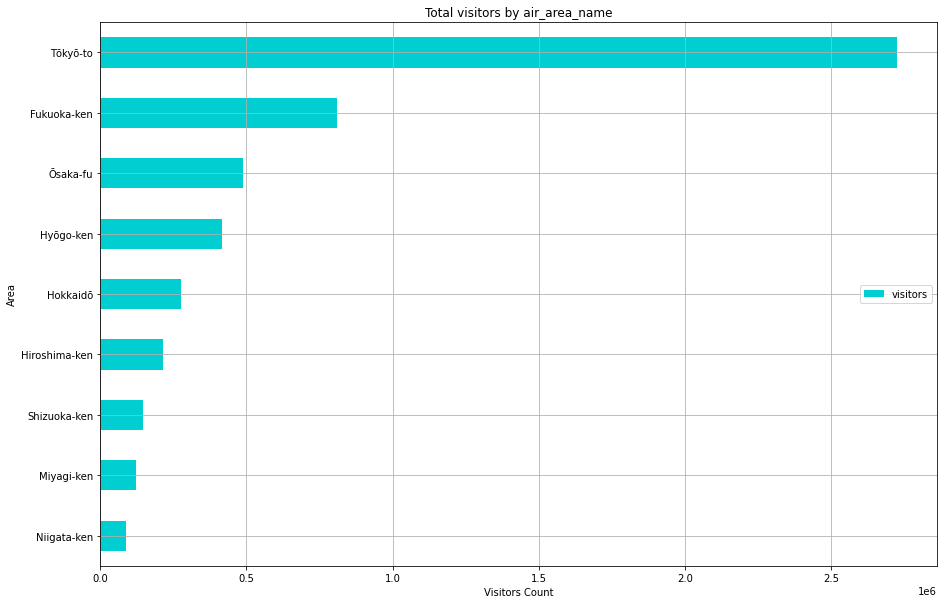

In [22]:
# 지역을 따로 구분하는 area 컬럼 생성
air_data['area'] = air_data['air_area_name'].map(lambda x: x.split()[0])

# 지역별 총 방문자 수 그래프
f,ax = plt.subplots(1,1, figsize=(15,10))
area_total = air_data.groupby(['area'])['visitors'].sum().to_frame()
area_total.sort_values(by='visitors',inplace=True)
area_total.plot(kind='barh',color= 'darkturquoise', grid=True, ax=ax, legend=True)
plt.ylabel('Area')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Total visitors by air_area_name", loc='center')

>분석  
>- 각 지역별 식당 방문객 수의 총합 그래프이다. 도쿄가 전체의 절반 이상을 차지한다.
>- 지역별로 사람들의 식당 이용 횟수에서 차이가 있다기보다는 활동인원이 많은 지역에서 총합이 높게 나타나는 것으로 생각된다.
>- 최상위 3개 지역을 보면 각각 도쿄/후쿠오카/오사카이며, 도시 규모도 물론 크지만 많은 관광객이 찾는 곳으로도 유명하다. 여행자의 경우 대부분의 식사를 식당에서 해결하는 만큼 해당 지역의 식당 방문객 수가 높은데 어느정도 영향을 줄 것으로 추측해볼 수 있다.

## 2-13. 지역별 평균 방문자 수

Text(0.5, 1.0, 'Average visitors by air_area_name')

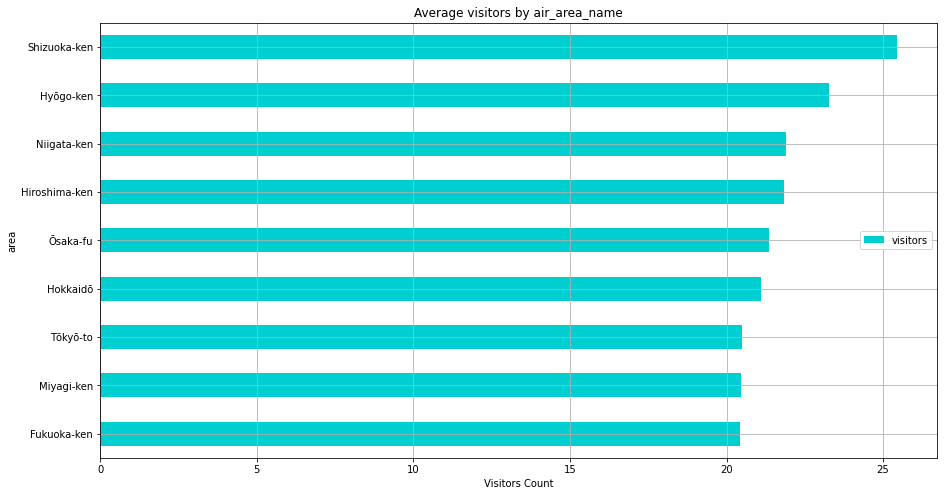

In [23]:
# 지역별 매장당 평균 방문자 수

f,ax = plt.subplots(1,1, figsize=(15,8))
area = air_data.groupby(['area'])['visitors'].mean().to_frame()
area.sort_values(by='visitors',inplace=True)
area.plot(kind='barh', color= 'darkturquoise', grid=True, ax=ax, legend=True)
plt.ylabel('area')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Average visitors by air_area_name", loc='center')

>분석  
>- 지역별 식당 방문객 수의 총합을 각 지역의 식당 수로 나눈 평균을 활용한 그래프이다.
>- 방문객 수의 총합에서 최상위권을 차지하던 도쿄, 후쿠오카, 오사카의 순위가 낮아진 것을 볼 수 있다. 해당 지역의 경우 많은 사람들이 활동하는 만큼 식당의 수도 많았음을 알 수 있다.
>- 방문객 수의 총합은 지역별로 차이가 많았지만 놀랍게도 대부분의 지역에서 식당의 방문객 평균 수는 20명 ~ 25명으로 평준화되어 있음을 볼 수 있다. 이 구간을 벗어나면 식당이 생겨나거나 사라진다고 추론해볼 수도 있겠다.
>- 위 그래프를 조금 더 세분화하여 분석을 심화한다면 예상 방문자 대비 식당이 적은 지역에 체인점을 추가로 차린다거나하는 등의 전략을 세울 수 있겠다.

----

# 3. Feature Engineering

## 3-1. 강수량, 평균 기온 구간화

In [24]:
# 강수량 구간화

precip1 = air_data[air_data['precipitation']<=8].index
precip2 = air_data[(air_data['precipitation']>8) & (air_data['precipitation']<=16)].index
precip3 = air_data[(air_data['precipitation']>16) & (air_data['precipitation']<=24)].index
precip4 = air_data[(air_data['precipitation']>24) & (air_data['precipitation']<=32)].index
precip5 = air_data[(air_data['precipitation']>32) & (air_data['precipitation']<=40)].index
precip6 = air_data[air_data['precipitation']>40].index

air_data['cat_precip'] = 0
air_data.loc[precip1, 'cat_precip'] = 1
air_data.loc[precip2, 'cat_precip'] = 2
air_data.loc[precip3, 'cat_precip'] = 3
air_data.loc[precip4, 'cat_precip'] = 4
air_data.loc[precip5, 'cat_precip'] = 5
air_data.loc[precip6, 'cat_precip'] = 6

__강수량 구간 별 평균 방문자 수 그래프__

Text(0.5, 1.0, 'Average Visitors by Precipitation')

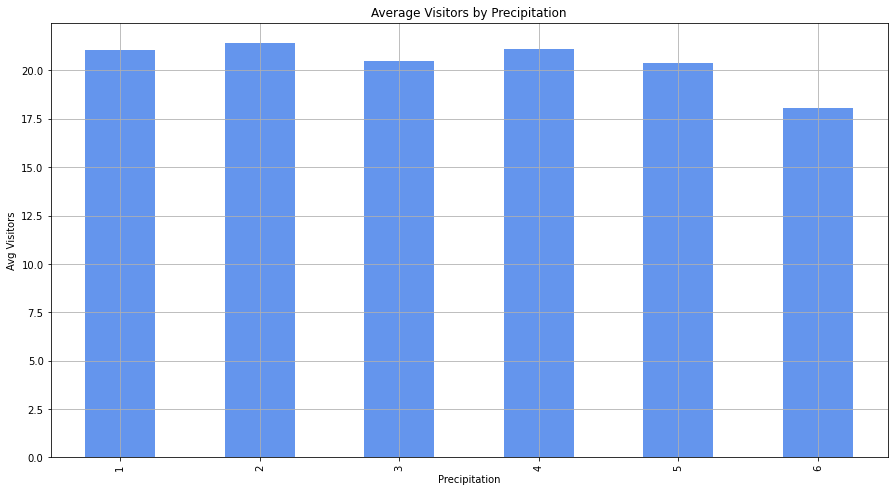

In [25]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['cat_precip'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'cornflowerblue', grid=True, ax=ax,legend=False)
plt.xlabel('Precipitation')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors by Precipitation')

>분석  
>- 강우량이 많아지는 구간 일 수록 방문자 수가 줄어드는 경향을 보인다.

In [26]:
# 평균 기온 구간화

avg_temp1 = air_data[air_data['avg_temperature']<=-10].index
avg_temp2 = air_data[(air_data['avg_temperature']>-10) & (air_data['avg_temperature']<=0)].index
avg_temp3 = air_data[(air_data['avg_temperature']>0) & (air_data['avg_temperature']<=10)].index
avg_temp4 = air_data[(air_data['avg_temperature']>10) & (air_data['avg_temperature']<=20)].index
avg_temp5 = air_data[(air_data['avg_temperature']>20) & (air_data['avg_temperature']<=30)].index
avg_temp6 = air_data[air_data['avg_temperature']>30].index

air_data['cat_avg_temp'] = 0
air_data.loc[avg_temp1, 'cat_avg_temp'] = 1
air_data.loc[avg_temp2, 'cat_avg_temp'] = 2
air_data.loc[avg_temp3, 'cat_avg_temp'] = 3
air_data.loc[avg_temp4, 'cat_avg_temp'] = 4
air_data.loc[avg_temp5, 'cat_avg_temp'] = 5
air_data.loc[avg_temp6, 'cat_avg_temp'] = 6

__일평균 기온 구간 별 평균 방문자 수 그래프__

Text(0.5, 1.0, 'Average Visitors Each Day Of Month')

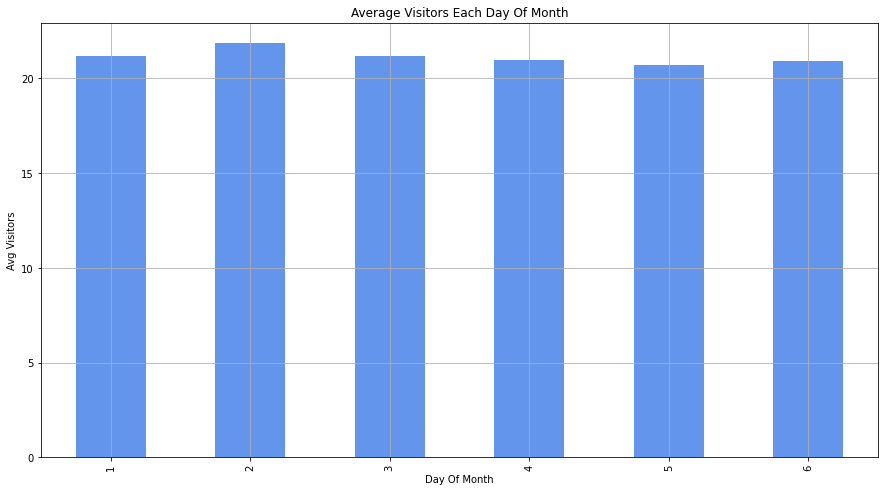

In [27]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= air_data.groupby(['cat_avg_temp'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'cornflowerblue', grid=True, ax=ax,legend=False)
plt.xlabel('Day Of Month')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Month')

## 3-2. 요일 별 방문자 수 컬럼 생성

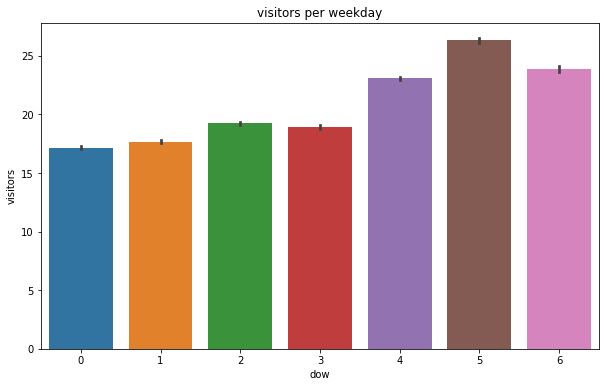

In [28]:
# 요일 별 방문자 수 컬럼 생성

dow_avg_visitor = air_data.groupby(['dow'])['visitors'].mean()
# 요일별 방문자 수 평균 계산

dow_avg_visitor = pd.DataFrame(dow_avg_visitor)
dow_avg_visitor.rename(columns={'visitors':'dow_avg_visitor'},inplace=True)

air_data = pd.merge(air_data,dow_avg_visitor,how='left', on=['dow']) 
# air_data에 추가

plt.figure(figsize=(10, 6))
sns.barplot(x = 'dow', y='visitors', data = air_data)
plt.title('visitors per weekday')
plt.show()

## 3-3. 일 별 방문자 수 컬럼 생성

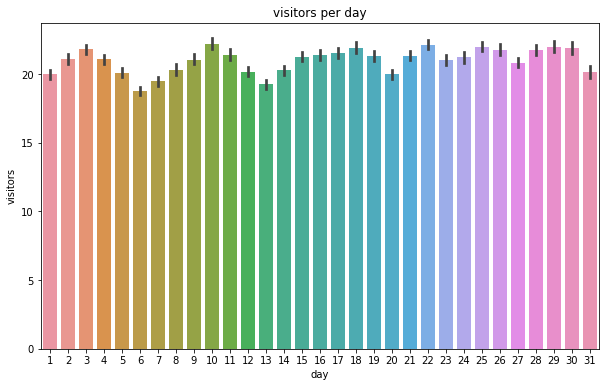

In [29]:
# 날짜 별 방문자 수 컬럼 생성

day_avg_visitor = air_data.groupby(['day'])['visitors'].mean()
# 날짜 별 방문자 수 평균 계산

day_avg_visitor = pd.DataFrame(day_avg_visitor)
day_avg_visitor.rename(columns={'visitors':'day_avg_visitor'},inplace=True)
air_data = pd.merge(air_data,day_avg_visitor,how='left', on=['day']) 
# air_data 에 추가

day = pd.Series(list(range(1,32)), name = 'day')

plt.figure(figsize=(10, 6))
sns.barplot(x = 'day', y='visitors', data = air_data)
plt.title('visitors per day')
plt.show()

## 3-4. 월 별 방문자 수 컬럼 생성

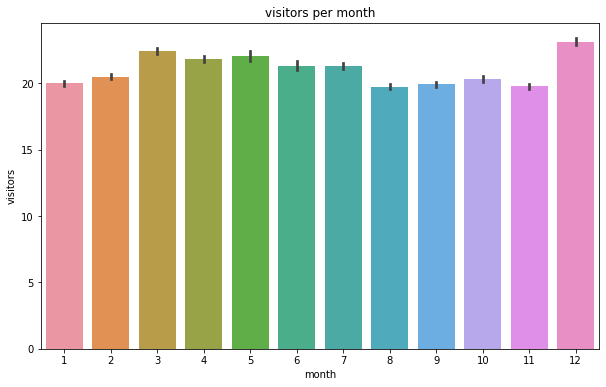

In [30]:
# 월 별 방문자 수 컬럼 생성

month_avg_visitor = air_data.groupby(['month'])['visitors'].mean()
# 월 별 방문자 수 평균 계산

month_avg_visitor = pd.DataFrame(month_avg_visitor)
month_avg_visitor.rename(columns={'visitors':'month_avg_visitor'},inplace=True)
air_data = pd.merge(air_data,month_avg_visitor,how='left', on=['month']) 
# air_data 에 추가

month = pd.Series(list(range(1,13)), name = 'month')

plt.figure(figsize=(10, 6))
sns.barplot(x = 'month', y='visitors', data = air_data)
plt.title('visitors per month')
plt.show()

## 3-5. 각 레스토랑 별 평균 방문자 수 컬럼 생성

In [31]:
# 식당 별 평균 방문자 수 컬럼 생성

store_avg_visitors = air_data.groupby(['air_store_id'])['visitors'].mean()
# 식당 별 방문자 수 평균 계산

store_avg_visitors = pd.DataFrame(store_avg_visitors)
store_avg_visitors.rename(columns={'visitors':'store_avg_visitors'},inplace=True)

air_data = pd.merge(air_data,store_avg_visitors,how='left', on=['air_store_id']) 
# air_data 에 추가

print(air_data.shape)

(252108, 28)


### 각 레스토랑 별 평균 방문자 이상치 처리

In [32]:
outlier = air_data[air_data['store_avg_visitors'] > 80]
# 평균 방문자수가 튀는 매장 확인

outlier

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,weight,...,month,week,quarter,area,cat_precip,cat_avg_temp,dow_avg_visitor,day_avg_visitor,month_avg_visitor,store_avg_visitors
214942,air_900d755ebd2f7bbd,2017-03-02,4,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,Thursday,0,0.384314,...,3,9,1,Tōkyō-to,2,3,18.922702,21.107756,22.400360,82.200000
215211,air_1c0b150f9e696a5f,2017-03-02,87,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Thursday,0,0.384314,...,3,9,1,Tōkyō-to,2,3,18.922702,21.107756,22.400360,115.470588
216036,air_1c0b150f9e696a5f,2017-03-03,96,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Friday,0,0.388836,...,3,9,1,Tōkyō-to,1,3,23.072737,21.788706,22.400360,115.470588
216556,air_1c0b150f9e696a5f,2017-03-04,114,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Saturday,0,0.393399,...,3,9,1,Tōkyō-to,1,3,26.313688,21.057714,22.400360,115.470588
217308,air_1c0b150f9e696a5f,2017-03-05,134,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Sunday,0,0.398006,...,3,9,1,Tōkyō-to,1,4,23.873362,20.076961,22.400360,115.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250508,air_1c0b150f9e696a5f,2017-04-20,86,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Thursday,0,0.661580,...,4,16,2,Tōkyō-to,1,4,18.922702,19.978030,21.816002,115.470588
250681,air_900d755ebd2f7bbd,2017-04-21,114,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,Friday,0,0.668558,...,4,16,2,Tōkyō-to,1,4,23.072737,21.332212,21.816002,82.200000
251071,air_1c0b150f9e696a5f,2017-04-21,89,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Friday,0,0.668558,...,4,16,2,Tōkyō-to,1,4,23.072737,21.332212,21.816002,115.470588
251459,air_900d755ebd2f7bbd,2017-04-22,83,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,Saturday,0,0.675596,...,4,16,2,Tōkyō-to,2,4,26.313688,22.125014,21.816002,82.200000


In [33]:
air_data[air_data['air_store_id'] == 'air_1c0b150f9e696a5f']
# 특이 케이스만 따로 확인

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,weight,...,month,week,quarter,area,cat_precip,cat_avg_temp,dow_avg_visitor,day_avg_visitor,month_avg_visitor,store_avg_visitors
215211,air_1c0b150f9e696a5f,2017-03-02,87,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Thursday,0,0.384314,...,3,9,1,Tōkyō-to,2,3,18.922702,21.107756,22.400360,115.470588
216036,air_1c0b150f9e696a5f,2017-03-03,96,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Friday,0,0.388836,...,3,9,1,Tōkyō-to,1,3,23.072737,21.788706,22.400360,115.470588
216556,air_1c0b150f9e696a5f,2017-03-04,114,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Saturday,0,0.393399,...,3,9,1,Tōkyō-to,1,3,26.313688,21.057714,22.400360,115.470588
217308,air_1c0b150f9e696a5f,2017-03-05,134,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Sunday,0,0.398006,...,3,9,1,Tōkyō-to,1,4,23.873362,20.076961,22.400360,115.470588
218110,air_1c0b150f9e696a5f,2017-03-06,101,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Monday,0,0.402655,...,3,10,1,Tōkyō-to,1,3,17.177009,18.749206,22.400360,115.470588
218559,air_1c0b150f9e696a5f,2017-03-07,86,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tuesday,0,0.407348,...,3,10,1,Tōkyō-to,1,3,17.672137,19.483672,22.400360,115.470588
219604,air_1c0b150f9e696a5f,2017-03-08,102,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Wednesday,0,0.412085,...,3,10,1,Tōkyō-to,1,3,19.230121,20.283643,22.400360,115.470588
220244,air_1c0b150f9e696a5f,2017-03-09,118,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Thursday,0,0.416865,...,3,10,1,Tōkyō-to,1,3,18.922702,21.046287,22.400360,115.470588
220717,air_1c0b150f9e696a5f,2017-03-10,105,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Friday,0,0.421690,...,3,10,1,Tōkyō-to,1,3,23.072737,22.211093,22.400360,115.470588
222026,air_1c0b150f9e696a5f,2017-03-11,139,Okonomiyaki/Monja/Teppanyaki,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Saturday,0,0.426560,...,3,10,1,Tōkyō-to,1,3,26.313688,21.406384,22.400360,115.470588


## 3-5. Train dataset 생성

In [34]:
# 필요한 columns 을 가지고 있는 train 만들기
train = air_data.copy()
train = train[['air_store_id','visit_date','visitors','weight','air_genre_name','holiday_flg','dow_avg_visitor','month_avg_visitor','day_avg_visitor','store_avg_visitors','area','cat_precip','cat_avg_temp']]
train

,air_store_id,visit_date,visitors,weight,air_genre_name,holiday_flg,dow_avg_visitor,month_avg_visitor,day_avg_visitor,store_avg_visitors,area,cat_precip,cat_avg_temp
0,air_fab092c35776a9b1,2016-01-01,19,2.707368e-14,Cafe/Sweets,1,23.072737,19.976758,19.981864,11.429825,Fukuoka-ken,1,3
1,air_f26f36ec4dc5adb0,2016-01-01,64,2.707368e-14,Izakaya,1,23.072737,19.976758,19.981864,39.950538,Tōkyō-to,1,3
2,air_d97dabf7aae60da5,2016-01-01,102,2.707368e-14,Cafe/Sweets,1,23.072737,19.976758,19.981864,37.754202,Tōkyō-to,1,3
3,air_39dccf7df20b1c6a,2016-01-01,55,2.707368e-14,Izakaya,1,23.072737,19.976758,19.981864,24.645435,Hyōgo-ken,1,5
4,air_79f528087f49df06,2016-01-01,42,2.707368e-14,Western food,1,23.072737,19.976758,19.981864,30.053269,Tōkyō-to,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_6a15e4eae523189d,2017-04-22,12,6.755955e-01,Bar/Cocktail,0,26.313688,21.816002,22.125014,19.320513,Tōkyō-to,2,4
252104,air_bf13014b6e3e60ca,2017-04-22,49,6.755955e-01,Cafe/Sweets,0,26.313688,21.816002,22.125014,33.034188,Tōkyō-to,2,3
252105,air_c52c63c781fe48f6,2017-04-22,41,6.755955e-01,Cafe/Sweets,0,26.313688,21.816002,22.125014,29.221774,Fukuoka-ken,1,4
252106,air_59cc9b2b209c6331,2017-04-22,12,6.755955e-01,Cafe/Sweets,0,26.313688,21.816002,22.125014,14.867089,Tōkyō-to,2,3


## 3-6. Test dataset 생성

train과 동일한 방식으로 전처리

In [35]:
sample_submission = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv')

test = sample_submission.copy()
test['air_store_id'] = test['id'].apply(lambda x: str(x)[:-11])
test['visit_date'] = test['id'].apply(lambda x: str(x)[-10:])
test = test.drop(['id', 'visitors'], axis = 1)

test = pd.merge(test,air_store_info,how='left', on=['air_store_id'])
test = pd.merge(test,date_info,how='left', on=['visit_date'])
test = test.drop(['day_of_week'], axis = 1)     # 'dow' column 과 겹치므로 삭제 

test = pd.merge(test,area_name_mapping,how='left', on=['air_area_name'])
test = pd.merge(test,weather_data,how='left', on=['weather_area', 'visit_date'])

test['visit_date'] = pd.to_datetime(test['visit_date'])
test['day'] = test['visit_date'].dt.day
test['dow'] = test['visit_date'].dt.weekday
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['week'] = test['visit_date'].dt.week
test['quarter'] = test['visit_date'].dt.quarter
test['visit_date'] = test['visit_date'].dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [36]:
test = pd.merge(test,dow_avg_visitor,how='left', on=['dow'])     # 요일 별 방문자 수 컬럼 생성
test = pd.merge(test,month_avg_visitor,how='left', on=['month'])   # 월 별 방문자 수 컬럼 생성
test = pd.merge(test,day_avg_visitor,how='left', on=['day'])    # 날짜 별 방문자 수 컬럼 생성
test = pd.merge(test,store_avg_visitors,how='left', on=['air_store_id'])     # 식당 별 평균 방문자 수 컬럼 생성
test['area'] = test['air_area_name'].map(lambda x: x.split()[0])    # 지역을 따로 구분하는 area 컬럼 생성
print(test.shape)
test['area'].value_counts()

(32019, 24)


Tōkyō-to         17160
Fukuoka-ken       4875
Ōsaka-fu          2886
Hyōgo-ken         2223
Hokkaidō          1716
Hiroshima-ken     1248
Shizuoka-ken       702
Miyagi-ken         663
Niigata-ken        546
Name: area, dtype: int64

In [37]:
precip1 = test[test['precipitation']<=8].index
precip2 = test[(test['precipitation']>8) & (test['precipitation']<=16)].index
precip3 = test[(test['precipitation']>16) & (test['precipitation']<=24)].index
precip4 = test[(test['precipitation']>24) & (test['precipitation']<=32)].index
precip5 = test[(test['precipitation']>32) & (test['precipitation']<=40)].index
precip6 = test[test['precipitation']>40].index

test['cat_precip'] = 0
test.loc[precip1, 'cat_precip'] = 1
test.loc[precip2, 'cat_precip'] = 2
test.loc[precip3, 'cat_precip'] = 3
test.loc[precip4, 'cat_precip'] = 4
test.loc[precip5, 'cat_precip'] = 5
test.loc[precip6, 'cat_precip'] = 6

In [38]:
avg_temp1 = test[test['avg_temperature']<=-10].index
avg_temp2 = test[(test['avg_temperature']>-10) & (test['avg_temperature']<=0)].index
avg_temp3 = test[(test['avg_temperature']>0) & (test['avg_temperature']<=10)].index
avg_temp4 = test[(test['avg_temperature']>10) & (test['avg_temperature']<=20)].index
avg_temp5 = test[(test['avg_temperature']>20) & (test['avg_temperature']<=30)].index
avg_temp6 = test[test['avg_temperature']>30].index

test['cat_avg_temp'] = 0
test.loc[avg_temp1, 'cat_avg_temp'] = 1
test.loc[avg_temp2, 'cat_avg_temp'] = 2
test.loc[avg_temp3, 'cat_avg_temp'] = 3
test.loc[avg_temp4, 'cat_avg_temp'] = 4
test.loc[avg_temp5, 'cat_avg_temp'] = 5
test.loc[avg_temp6, 'cat_avg_temp'] = 6

In [39]:
# 필요한 컬럼만 사용
test = test[['air_store_id','visit_date','air_genre_name','weight','holiday_flg','dow_avg_visitor','month_avg_visitor','day_avg_visitor','store_avg_visitors','area','cat_avg_temp','cat_precip']]
test

,air_store_id,visit_date,air_genre_name,weight,holiday_flg,dow_avg_visitor,month_avg_visitor,day_avg_visitor,store_avg_visitors,area,cat_avg_temp,cat_precip
0,air_00a91d42b08b08d9,2017-04-23,Italian/French,0.682692,0,23.873362,21.816002,21.007387,26.081897,Tōkyō-to,4,1
1,air_00a91d42b08b08d9,2017-04-24,Italian/French,0.689848,0,17.177009,21.816002,21.214331,26.081897,Tōkyō-to,4,1
2,air_00a91d42b08b08d9,2017-04-25,Italian/French,0.697064,0,17.672137,21.816002,21.996978,26.081897,Tōkyō-to,4,1
3,air_00a91d42b08b08d9,2017-04-26,Italian/French,0.704340,0,19.230121,21.816002,21.770895,26.081897,Tōkyō-to,4,1
4,air_00a91d42b08b08d9,2017-04-27,Italian/French,0.711677,0,18.922702,21.816002,20.820884,26.081897,Tōkyō-to,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,Bar/Cocktail,0.961909,0,26.313688,22.009313,20.820884,5.089219,Tōkyō-to,5,1
32015,air_fff68b929994bfbd,2017-05-28,Bar/Cocktail,0.971321,0,23.873362,22.009313,21.753372,5.089219,Tōkyō-to,5,1
32016,air_fff68b929994bfbd,2017-05-29,Bar/Cocktail,0.980807,0,17.177009,22.009313,21.995716,5.089219,Tōkyō-to,5,1
32017,air_fff68b929994bfbd,2017-05-30,Bar/Cocktail,0.990366,0,17.672137,22.009313,21.864183,5.089219,Tōkyō-to,5,1


## 3-7. One-Hot Encoding

레스토랑 장르, 지역, 날씨 구간화 데이터 원핫인코딩

In [40]:
encoded_train = pd.get_dummies(data = train, columns =['air_genre_name','area','cat_avg_temp','cat_precip'])
print(encoded_train.shape)

(252108, 44)


In [41]:
encoded_test = pd.get_dummies(data = test, columns =['air_genre_name','area','cat_avg_temp','cat_precip'])
print(encoded_test.shape)

(32019, 41)


In [42]:
target_train = encoded_train['visitors']   
# 목표 변수 컬럼 분리

encoded_train = encoded_train.drop(['visitors', 'air_store_id', 'visit_date', 'cat_avg_temp_1','cat_avg_temp_6'], axis=1)
encoded_test = encoded_test.drop(['air_store_id', 'visit_date'], axis=1)
print(encoded_train.shape)
print(encoded_test.shape)

(252108, 39)
(32019, 39)


## 3-8. Training Set, Validation Set 분리
주어진 Training set 에서 다시 training set 과 validation set 을 분리한다.

In [43]:
X_train, X_val, y_train, y_val = train_test_split(encoded_train,
                                                  target_train, 
                                                  test_size = 0.2, 
                                                  random_state = 42)
print(X_train.shape)
print(X_val.shape)

(201686, 39)
(50422, 39)


----
# 4. 모델 생성 및 하이퍼파라미터 튜닝.  Modeling, HyperParameter Tunning
## 4-1. 선형 회귀 LinearRegression

In [44]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [45]:
def rmsle(y_true,y_pred):  #RMSLE  함수 정의

    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

score = make_scorer(rmsle, greater_is_better=False)

In [46]:
y_val_pred = model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)

print(val_rmsle) # validation set 의 RMSLE

0.6269369449186132


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# 해당 모델로 test set 예측
final_visitors  = model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_linearReg.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_linearReg.csv 파일 저장 완료'.format(val_rmsle))

submission_0.627_linearReg.csv 파일 저장 완료


----

## 4-2. KNeighbors Regression

In [48]:
# hyperparameters
parameters = {'n_neighbors': [5, 10, 15]}

# model
knn = KNeighborsRegressor(n_jobs=-1)

# cross validation
knn_cv = GridSearchCV(estimator=knn,
                      param_grid=parameters,
                      scoring=score,
                      n_jobs=-1,
                      cv=3,
                      verbose=10,
                      return_train_score=True)
knn_cv.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  6.8min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.0min finished


GridSearchCV(cv=3, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

In [49]:
knn_cv.best_params_

{'n_neighbors': 15}

In [50]:
knn_model = KNeighborsRegressor(n_neighbors=15,n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=15)

In [51]:
y_val_pred = knn_model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)  # validation set 의 RMSLE

print(val_rmsle)

0.5857358129444269


In [52]:
# 해당 모델로 test set 예측
final_visitors  = knn_model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_knn.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_knn.csv 파일 저장 완료'.format(val_rmsle))

submission_0.586_knn.csv 파일 저장 완료


----

## 4-3. SGD Regression

In [53]:
std = StandardScaler() 
X_train_std = std.fit_transform(X_train)
X_val_std = std.fit_transform(X_val)

In [54]:
sgd_reg = SGDRegressor()
# parameters
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1]}

# cross validation
sgd_reg_cv = GridSearchCV(estimator=sgd_reg,
                      param_grid=parameters,
                      scoring=score,
                      n_jobs=-1,
                      cv=5,
                      verbose=10,
                      return_train_score=True)
sgd_reg_cv.fit(X_train_std,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.7s finished


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

In [55]:
sgd_reg_cv.best_params_

{'alpha': 0.1}

In [56]:
sgd_model = SGDRegressor(alpha=0.1)
sgd_model.fit(X_train_std, y_train)

SGDRegressor(alpha=0.1)

In [57]:
y_val_pred = sgd_model.predict(X_val_std)

val_rmsle = rmsle(y_val, y_val_pred)    # validation set 의 RMSLE

print(val_rmsle)

0.6247486040028468


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# 해당 모델로 test set 예측
final_visitors  = sgd_model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_sgd.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_sgd.csv 파일 저장 완료'.format(val_rmsle))

submission_0.625_sgd.csv 파일 저장 완료


----
## 4-4. DecisionTree

In [59]:
dt = DecisionTreeRegressor()
# hyperparameters
parameters = {'max_depth': [1, 5, 10, 50],
              'min_samples_split' : [10, 100, 500]}
# cross validation
dt_cv = GridSearchCV(estimator=dt,
                      param_grid=parameters,
                      scoring=score,
                      n_jobs=-1,
                      cv=3,
                      verbose=10,
                      return_train_score=True)
dt_cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   16.4s finished


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [10, 100, 500]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

In [60]:
dt_cv.best_params_

{'max_depth': 50, 'min_samples_split': 100}

In [61]:
dt_model = DecisionTreeRegressor(max_depth = 50, min_samples_split = 100)
dt_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=50, min_samples_split=100)

In [62]:
y_val_pred = dt_model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)    # validation set 의 RMSLE

print(val_rmsle)

0.5686805093827447


In [63]:
# 해당 모델로 test set 예측
final_visitors  = dt_model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_dt.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_dt.csv 파일 저장 완료'.format(val_rmsle))

submission_0.569_dt.csv 파일 저장 완료


----
## 4-5. RandomForest

In [64]:
rf = RandomForestRegressor()
# hyperparameters
parameters = {'max_depth': [1, 5, 10],
              'n_estimators' : [10, 50, 100]}
# cross validation
rf_cv = GridSearchCV(estimator=rf,
                     param_grid=parameters,
                     cv=3,
                     scoring=score,
                     return_train_score=True,
                     n_jobs=1)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [10, 50, 100]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False))

In [65]:
rf_cv.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [66]:
rf_model = RandomForestRegressor(max_depth = 10, n_estimators = 100, n_jobs=1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_jobs=1)

In [67]:
y_val_pred = rf_model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)   # validation set 의 RMSLE

print(val_rmsle)

0.5806722986010238


In [68]:
# 해당 모델로 test set 예측
final_visitors  = rf_model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_rf.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_rf.csv 파일 저장 완료'.format(val_rmsle))

submission_0.581_rf.csv 파일 저장 완료


----


## 4-6. XGBoost

In [75]:
# hyperparameters
parameters = {'learning_rate':[0.1,0.01],
              'min_child_weight':[0.8,0.9,1],
              'max_depth': [2,4,8]}

# XGBoost optimized matrix
train_matrix = xgb.DMatrix(data=X_train,label=y_train)
val_matrix = xgb.DMatrix(data=X_val,label=y_val)

# model
xgb_reg = xgb.XGBRegressor(tree_method='gpu_hist')

# cross validation
xgb_reg_cv = GridSearchCV(estimator=xgb_reg,
                     param_grid=parameters,
                     cv=3,
                     return_train_score=True,
                     n_jobs=-1,
                     scoring=score)
xgb_reg_cv.fit(X=X_train,y=y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='gpu_hist',
        

In [76]:
xgb_reg_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 0.8}

In [71]:
xgb_model = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 8, min_child_weight= 0.8)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=0.8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
y_val_pred = xgb_model.predict(X_val)

val_rmsle = rmsle(y_val, y_val_pred)    # validation set 의 RMSLE

print(val_rmsle)

0.5705353367283521


In [73]:
# 해당 모델로 test set 예측
final_visitors  = xgb_model.predict(encoded_test)

final = sample_submission.copy()
final['visitors'] = final_visitors

# 예측 결과를 csv 파일로 저장
final.to_csv('submission_{:.3f}_xgb.csv'.format(val_rmsle), index=False)
print('submission_{:.3f}_xgb.csv 파일 저장 완료'.format(val_rmsle))

submission_0.571_xgb.csv 파일 저장 완료


# 최종 정리

## RMSLE Score
|Model|Score|
|----|----|
|Decision Tree|0.569|
|XGBoost|0.571|
|Random Forest|0.581|
|KNeighbors Regression|0.586|
|SGD Regression|0.625|
|Linear Regression|0.627|

## 회고

- 처음 접하는 시계열 문제 분석이라서 여러가지로 어려움이 많았다
- 처음부터 끝까지 다 하기에는 시간도 없고 실력도 모자라서 이미 진행한 사람들의 노트북을 많이 참고해야 했던 것이 아쉽다
- 성능을 더 올릴 수 있을 것 같지만 시행하지 못한 방안들
1. 한쪽으로 치우쳐있는 visitors 를 로그변환 
2. 평일과 주말, 평일이지만 공휴일 각각의 특징을 좀 더 분석하고 데이터로 표현하기
3. 공식적으로 주어진 데이터 중에 주로 방문자 데이터만 이용하고 예약자 데이터는 거의 사용하지 못함. 예약자와 방문자의 특성 차이를 분석하고 학습에 반영하기
4. 외부데이터 중 날씨데이터셋을 이용하였는데, 그 중에서도 일부만 활용했음. 좀 더 활용해서 분석하기
5. 위도와 경도 데이터는, 실제 식당의 값이 아니기도 하고, 지역명으로 충분히 커버가 가능할 거라 생각해서 삭제했음. 다른 특성이 나타날 수 있는지 비교분석
6. 주요 데이터 분석 그래프를 보고 분석은 조원들끼리 상의하며 직접 했지만 그리는 코드 자체는 다른 노트북을 많이 참고함. 좀 더 효율적인 시각화 방안이 없을지 더 고민하고 직접 그려보기
7. 시간이 충분하지 못해서 하이퍼파라미터를 최적화 하지 못함
8. SVM모델로 모델링 해보았으나 시간이 너무 오래 걸리는 바람에 중간에 중단
9. 시계열 분석에 가장 적합하다는 ARIMA 를 도전해보았으나 실패

## 참고 자료

### 깃허브

1. [https://github.com/junaidnasirkhan/Restaurant-Visitor-Forecasting/blob/master/Restaurant Visitor Forecasting.ipynb](https://github.com/junaidnasirkhan/Restaurant-Visitor-Forecasting/blob/master/Restaurant%20Visitor%20Forecasting.ipynb)  
전체적인 흐름을 따라간 노트북.
다중공선성 관련작업이나 날씨 데이터를 세밀하게 다루는 등 복잡한 내용은 스킵하였지만
그래프 그리는 것과 모델링구조를 참고

2. [https://github.com/anki1909/Recruit-Restaurant-Visitor-Forecasting](https://github.com/anki1909/Recruit-Restaurant-Visitor-Forecasting)  
세세한 코드 카피보다는 초반에 진행 방향을 참고

### 노트북

1. [https://www.kaggle.com/asindico/a-japanese-journey](https://www.kaggle.com/asindico/a-japanese-journey)  
참고자료 2의 캐글 코드.
마찬가지로 코드 내용 보다는 방향성 잡는데 큰 영향을 받음

2. [https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda](https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda)
3. [https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r/report#overview-file-structure-and-content](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r/report#overview-file-structure-and-content)  
둘 다 R로 작성되어 있어서 코드는 참고하지 못했지만 데이터 전처리와 분석방향을 참고

### 블로그

1. [https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073](https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073)  
참고자료 1의 블로그

2. [https://ichi.pro/ko/leseutolang-bangmunja-yecheug-mojib-274807169618035](https://ichi.pro/ko/leseutolang-bangmunja-yecheug-mojib-274807169618035)  
참고자료 2의 블로그